# STAT2005 Computer Simulation 

## Lecture 9 - Monte Carlo Integration 

**Felix Chan, School of Economics and Finance**

## Introduction 

- Objective is to introduce the concept of Monte Carlo Integration. 
- Keeping it simple and focus on one-dimensional problem only. Even though conventional numerical techniques work fine in most of these cases. 
- Only scratching the surface and involves a lot of hand-waving. See [here](https://catalogue.curtin.edu.au/primo-explore/fulldisplay?docid=CUR_ALMA51110532410001951&context=L&vid=CUR_ALMA&lang=en_US&search_scope=CurtinBlended&adaptor=Local%20Search%20Engine&tab=default_tab&query=any,contains,Introduction%20to%20Probability%20Simulation%20and%20Gibbs%20Sampling%20with%20R&offset=0) or [here](https://catalogue.curtin.edu.au/primo-explore/fulldisplay?docid=CUR_ALMA51128022240001951&context=L&vid=CUR_ALMA&lang=en_US&search_scope=CurtinBlended&adaptor=Local%20Search%20Engine&tab=default_tab&query=any,contains,Introduction%20to%20Bayesian%20Econometrics&offset=0) for more technical discussions. 


## Motivation 

Often we need to evaluate
$$ F=\int^b_a f(x) dx $$
1. The anti-derivative of $f(x)$ is not always available. An obvious example is the standard normal density. 
2. Can always use standard (deterministic) numerical methods, but implementations are not always straightforward, especially for improper integral, i.e. $a\rightarrow -\infty$ or $b\rightarrow \infty$. 
3. We also want to see if we can improve accuracy.  

In [130]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.integrate as spi
import scipy.optimize as spo
import pandas as pd
import copy as copy
import matplotlib.pyplot as plt
from matplotlib import animation 

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,9]
plt.rcParams['animation.html'] = 'html5'

## Numerical Methods

- The Riemann Sum gives the most obvious approximation:

$$ 
    \begin{align} 
    \int^b_a f(x) dx =& \lim_{n\rightarrow \infty} \sum^{n-1}_{i=0} f\left (a+i\frac{b-a}{n} \right )\frac{b-a}{n} \\
              \approx & \sum^{n-1}_{i=0} f\left (a+i\frac{b-a}{n} \right )\frac{b-a}{n}.      
    \end{align}
 $$
- For any fixed number of rectangles $n$, we calculate their areas by setting the width to $(b-a)/n$ and the height to $f(a+i(b-a)/n)$. 
- Let's do an example. Consider the integral:
$$ \int^{\pi}_0 \sin (x) dx $$
which we know the analytical answer to be 2. 

In [3]:
def Riemann(f,bound,n=100):
    """
    Calculate the Riemann sum of a given function, f, over the interval bound = [a,b] with fixed number of partitions, n. 
    Inputs:
        f: a python function. 
        bound: (2,) list, [a,b] containing the lower bound, a, and upper bound, b.
        n: int. The number of partitions in the bound. 
    Output:
        A: the Riemann sum. 
    
    """
    A = 0
    delta = (bound[1]-bound[0])/n
    for i in np.arange(0,n):
        A += f(bound[0]+i*delta)*delta
    return A

In [4]:
f = lambda x: np.sin(x)
bound = [0,np.pi]
A = Riemann(f,bound)
A

1.9998355038874436

- This seems to work well (and fast). 
- The two shortfalls of the Riemann Sum type approaches:
    1. Slightly trickier for improper integral, i.e. no upper or lower bound.
    2. slightly trickier for multivariate functions. The partitions and the order of sum may become important. 
- We are going to introduce two alternatives, both belong to the class of methods calls *Monte Carlo Integration*. 

## Hit and Miss

- The first method is called Hit and Miss (no, not the TV show, although our paint-ball gun does make a come back). 
- It is a variation of the accept-reject method. 
- The algorithm goes as follows:
    1. Draw a rectangle around the function over the interval of integration. That is, $(x,f(x)) \in B$ where $B=[a,b]\times [c,d]$ is the rectangle for all $x\in [a,b]$. 
    2. Pick up our trusted paint-ball gun and shoot at the picture $N$ times randomly. 
    3. Count the number of hits which is defined to be those landed below the function. 
    4. The integral can then be approximated as 
    $$ \frac{\text{# of hits}}{N}{(b-a)(d-c)} + c(b-a).$$
- Let's use this to evaluate 
    $$ \int^{2\pi}_0 \sin(x) dx$$

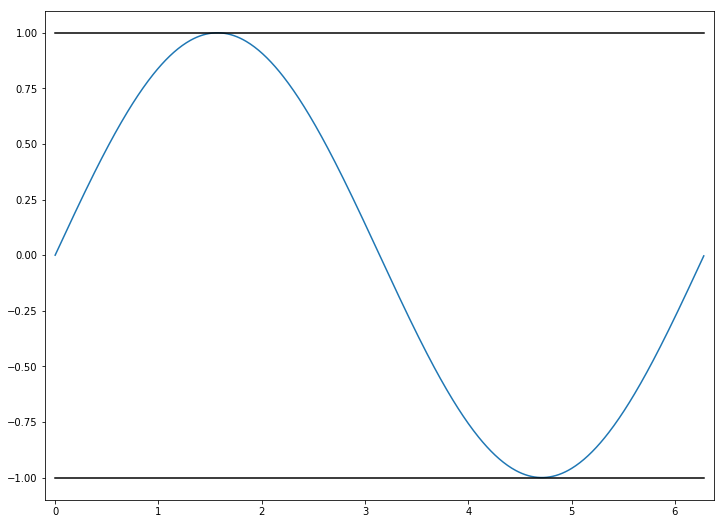

In [5]:
f = lambda x: np.sin(x)
xset = np.arange(0,2*np.pi,0.01)
fset = f(xset)
N = 1500
n_hit = np.zeros(N)
n_miss = np.zeros(N)
aset = []
hit =[]
miss = []
color_index = []
for i in np.arange(0,N):
    x = sps.uniform.rvs(0,2*np.pi)
    y = sps.uniform.rvs(-1,2)
    aset.append([x,y])
    if f(x) > y:
        hit.append([x,y])
        color_index.append(1)
        if i!=0:
            n_hit[i] = n_hit[i-1] +1
            n_miss[i] = n_miss[i-1]
        else:
            n_hit[i] = 1
            n_miss[i]= 0
    else:
        miss.append([x,y])
        color_index.append(0)
        if i!=0:
            n_hit[i] = n_hit[i-1]
            n_miss[i] = n_miss[i-1] +1
        else:
            n_hit[i] = 0
            n_miss[i]= 1
aset = np.array(aset)
hit = np.array(hit)
miss = np.array(miss)
fig, ax = plt.subplots()
ax.set_xlim(-0.1,2*np.pi+0.1)
ax.set_ylim(-1.1,1.1)
ax.plot(xset, fset)
ax.plot(xset, np.ones(len(xset)),xset, -np.ones(len(xset)),color=(0,0,0))
area = n_hit*4*np.pi/(n_hit+n_miss) - 2*np.pi

def hit_miss(i):
    if color_index[i] == 0:
        ax.scatter(aset.transpose()[0][i], aset.transpose()[1][i], c='r')
    else:
        ax.scatter(aset.transpose()[0][i], aset.transpose()[1][i], c='b')
    ax.set_title('Hit: {0} Miss: {1} Area Estimate: {2}'.format(n_hit[i], n_miss[i], area[i]))    
    

In [6]:
ani = animation.FuncAnimation(fig,hit_miss,frames=np.arange(len(aset)))
ani

Text(0.5,1,'Integral estimates')

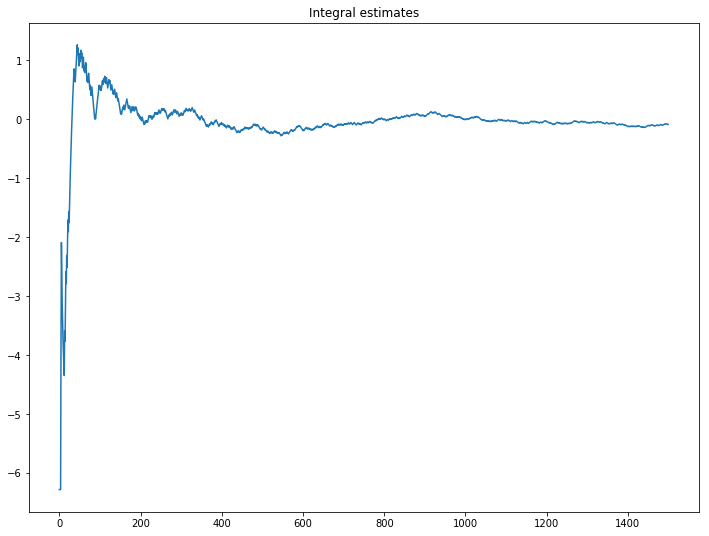

In [8]:
xset = np.arange(N)
plt.plot(xset, area)
plt.title('Integral estimates')

- How does this work? 
- As in the accept-reject method, the random shooting is equivalent to randomly selecting a point within the box. This can be generated by drawing from two uniform random variables, $x\sim U(a,b)$ and $y\sim U(c,d)$. 
- Now define the region $D$ which covers the area under the function within the box. 
- Since $x,y$ are both uniformly distributed, $\displaystyle\Pr \left[ (x,y) \in D \right ] = \frac{D}{(b-a)(d-c)}$ gives the ratio between the area under the function and the total area of the box. 
- Define a random variable $Z = \mathbb{1} (x,y)$ such that $Z=1$ if $(x,y)\in D$ and $0$ otherwise. Then 
$$\mathbb{E} (Z) = \Pr  \left[ (x,y) \in D \right ]$$
which can be estimated by the number of hit over the total number of "shots". 
- This is because as the number of shots goes to infinity, they will eventually cover every point within the box and thus the number of hits gives the area under function. 


- The only minor twist is that the bottom of the box, $c$, may be above or below the $x$-axis. 
- If it is above the $x$-axis, we need to include the additional area between $c$ and the $x$-axis. Since the area is under $c$ it is not included in the box. 
- If it is below the $x$-axis, then the approximation included additional area which we need to substract. Recall area bounded above by the $x$-axis and bounded below by the function is negative. 
- This can be achieved by adding $c(b-a)$. 
- Note: $c$ is positive if it is above the $x$-axis (adding extra area) and $c$ is negative if it is below the $x$ axis (removing extra area). 

- Case when $c=0$

![c0](./pics/c0.png)

- Case when $c>0$. In this case, Hit and Miss gives the pink area and the green area is $c(b-a)$. 

![cgeq0](./pics/cgeq0.png)

- Case $c<0$. In this case, Hit and Miss gives the pink and green area but anything below the $x$ axis should be negative. So the integral is the Hit-and-miss area takes away the green and blue area which is $c(b-a)$.  

![cleq0](./pics/cleq0.png)

- An advantage of hit and miss is that it is easy to implement. 
- It is fairly robust when the number of shots is high but not particularly fast, especially for simple function (The Riemann sum did a much better job with a lot less partitions). 
- It is also not particularly useful for improper integral. 
- So let's consider another alternative. 

- Reconsider the Riemann sum 

$$ 
\begin{align}
\int^b_a f(x) dx =& \lim_{n\rightarrow \infty} \sum^{n-1}_{i=0} f\left (a+i\frac{b-a}{n} \right )\frac{b-a}{n} \\
              \approx & \sum^{n-1}_{i=0} f\left (a+i\frac{b-a}{n} \right )\frac{b-a}{n}\\
              =& (b-a) \sum^{n-1}_{i=0} f\left (a+i\frac{b-a}{n} \right )\frac{1}{n}
              \end{align}
              $$
              
- Define a uniformly distributed discrete random variable, $U$, with $n$ outcomes and define $\displaystyle \Delta = \frac{b-a}{n}$ such that the sample space of $U$ is $\Omega = \{a, a+\Delta,\ldots, a+i\Delta, \ldots b \}$.
- Since $U$ is uniformly distributed, so $\displaystyle \Pr (U=u) = \frac{1}{n}$ for all $u\in \Omega$.
- Therefore, the Riemann sum can be interpreted as 
$$ \lim_{n\rightarrow \infty} (b-a)\mathbb{E} \left [ f(U) \right ].$$

- This means we can approximate the integral by estimating the expectation. 
- This can be done by randomly drawing from $U_i\sim U(a,b)$ $N$ times and calculate the average:
$$ \hat{\mathbb{E}} [f(U)] = N^{-1}\sum^N_{i=1} f(U_i).$$

In [23]:
def MCI_uniform(f, bound, N):
    """
    Integrate a given function, f, over the interval bound = [a,b] with fixed number of partitions, n via Monte Carlo Integration. 
    Inputs:
        f: a python function. 
        bound: (2,) list, [a,b] containing the lower bound, a, and upper bound, b.
        N: int. The number of random draws
    Output:
        A: the estimated integral. 
    
    """
    A = 0 
    delta = bound[1]-bound[0]
    u = sps.uniform.rvs(bound[0], delta, size=N)
    A = np.mean(f(u))*delta
    return A

In [30]:
f = lambda x: np.sin(x)
bound = [0, 2*np.pi]
N = 500000
A = MCI_uniform(f,bound,N)
A

0.005801740083191816

Another example:
$$\Pr ( -1.96 < X < 1.96 )$$ 
where $X$ is a random variable follows the standard normal distribution. This is equivalent to 
$$\int^{-1.96}_{1.96} \phi(x) dx$$. 

In [31]:
g = lambda x: sps.norm.pdf(x)
bound = [-1.96,1.96]
N = 10000
A = MCI_uniform(g,bound,N)
A

0.9483722476483416

- The method relies on the assumption that $\hat{\mathbb{E}} [f(U)] = N^{-1}\sum^N_{i=1} f(U_i)$ converges to $\mathbb{E} [f(U)]$.
- This hinges on the validity of the **Weak Law of Large Number** (WLLN). 

<div style="background:rgb(240,212,211)">
    <p><b>Weak Law of Large Number</b> </p>
        <p>Let $\{ y_i \}^N_{i=1}$ be a sequence of independently and identically distributed random variable such that $\mathbb{E} |y_i| < \infty$. Define $\mu = \mathbb{E} (y_i)$ and $\bar{y}_N = N^{-1} \sum^N_{i=1} y_i$ then for all $\varepsilon > 0$, 
            $$ \lim_{n\rightarrow \infty} \Pr \left ( |\bar{y}_N - \mu| < \varepsilon \right ) = 1. $$ </p> 
            
<p>This is often written as $\bar{y} \overset{p}{\rightarrow} \mu$ or $\text{plim}\; \bar{y} = \mu$. </p>
</div>

- The basic implication is that the sample average tends towards the expected value when $N$ is large. 
- Therefore the proposed method will work as long as $\mathbb{E} | f(U) |$ is finite which is often not too difficult to justify. 
- The full proof of WLLN is a little involved. We will prove a weaker version which requires finite variance of $y_i$. 

**Proof of WLLN**

We first prove the following. Let $X:\Omega \rightarrow \mathbb{R}^+$ be a continuous random variable with density $f(x)$, then 
        $$\Pr (X > k) \leq \frac{\mathbb{E} (X)}{k}.$$
Note that 
$$\begin{align} 
    \mathbb{E} (X) =& \int^k_0 xf(x) dx + \int^\infty_k xf(x) dx \\
    \geq & \int^\infty_k xf(x) dx \\
    \geq & \int^\infty_k kf(x) dx \\
    =& k \int^\infty_k f(x) dx \\
    =& k\Pr ( X> k)
    \end{align}
    $$
This result is often called the *Markov's Inequality*. 

Now, let $X= (\bar{Y}_N-\mu)^2$ where $\mathbb{E} (Y_i) = \mu$ and $Var(\bar{Y}_N) = \displaystyle \frac{\sigma^2_Y}{N}$. Let $k=\varepsilon$ then from the Markov's inequality:
$$\begin{align}
    \Pr \left [ ( \bar{Y}_N-\mu)^2 > \varepsilon^2 \right ] \leq & \frac{\sigma^2_Y}{N\varepsilon^2} \\
    \Pr \left [ |\bar{Y}_N-\mu| > \varepsilon \right ] \leq & \frac{\sigma^2_Y}{N\varepsilon^2} \\
    \Pr \left [ |\bar{Y}_N-\mu| \leq \varepsilon \right ] \geq & 1- \frac{\sigma^2_Y}{N\varepsilon^2} 
    \end{align}
    $$
Let $N\rightarrow \infty$ gives the result. 

**Exercise** 

Can you use computer simulation to provide support for WLLN? 

## Importance Sampling
- The importance of WLLN is that it ensures the convergence of sample averages to an integral. This allows us to evaluate improper integral as well as proper integral. 
- Consider 
    $$ \int^\infty_{-\infty} f(x) dx. $$
Let $g(x)$ be a PDF define over $\mathbb{R}$ then 

$$ 
    \begin{align} 
    \int^\infty_{-\infty} f(x) dx =& \int^\infty_{-\infty} \frac{f(x)}{g(x)} g(x) dx \\
                                 =& \mathbb{E} \left ( \frac{f(x)}{g(x)} \right ). 
     \end{align}
$$

Therefore, under the conditions for WLLN, we can approximate the integral by $N^{-1} \sum^N_{i=1} \displaystyle \frac{f(X_i)}{g(X_i)}$ where $X_i$ is a random draw from the random variable following the probability density function $g$. 

## A Financial Application 
It is well known the the distribution of daily financial returns is not normal. One way to approximate the return distribution is via the matching of sample moments. That is, construct a density function with the same first $k$ moments as the sample data. Let $f(x;\lambda)$ be a density function with the parameter vector $\lambda$, then we are seeking the vector such that 
$$\begin{align}
    \int f(x;\lambda) dx &= 1 \\
    \int xf(x;\lambda) dx &=  {\hat{\mu}}_1 \\
    \int x^2f(x;\lambda) dx &=  \hat{\mu} _2 \\
                            &\vdots \\
    \int x^kf(x;\lambda) dx &=  \hat{\mu} _k \\
    \end{align}
    $$
Now let's assume the density function takes the form
$$ f(x;\lambda) = Q^{-1} \exp \left ( \lambda_1 x + \lambda_2 x^2 + \ldots + \lambda_k x^k \right ).$$

- Note that for $f(x;\lambda)$ to be a proper density $Q =\int^\infty_{-\infty} \exp \left ( \lambda_1 x + \lambda_2 x^2 + \ldots + \lambda_k x^k \right ) dx$. 
- Constant like $Q$ is often called the *normalising constant*.  
- There is no analytical solution for $Q$ when $k>2$. 
- Note that 
$$ \begin{align}
    Q =& \sqrt{2\pi} \int^\infty_{-\infty} \exp \left ( \lambda_1 x + (\lambda_2+0.5) x^2 + \ldots + \lambda_k x^k \right )\phi(x) dx \\
    =& \sqrt{2\pi} \mathbb{E} \left [ \exp \left ( \lambda_1 x + (\lambda_2+0.5) x^2 + \ldots + \lambda_k x^k \right ) \right ]
    \end{align}
    $$
- So we can approximate the integral by 
$$ \frac{\sqrt{2\pi}}{N} \sum^N_{i=1} \exp \left ( \lambda_1 x_i + (\lambda_2+0.5) x_i^2 + \ldots + \lambda_k x_i^k \right )$$
where $x_i$ is a random draw from the standard normal density.
- The assumptions required for WLLN is crucial here but the conditions are little tedious (and technical). So we will assume they hold. For details, see 
[here][annoy].

[annoy]: https://catalogue.curtin.edu.au/primo-explore/fulldisplay?docid=TN_sciversesciencedirect_elsevierS0893-9659(03)00030-2&context=PC&vid=CUR_ALMA&lang=en_US&search_scope=CurtinBlended&adaptor=primo_central_multiple_fe&tab=default_tab&query=any,contains,Maximum%20entropy%20solutions%20and%20moment%20problem%20in%20unbounded%20domains&sortby=rank&offset=0

In [219]:
def MED_kernel(x, l):
	"""
		Density of a Maximum Entropy Density given parameter l.
        Inputs:
            x: (T,) numpy array. 
            l: (k,) parameter vector. 
        Output:
            f: MED
	"""
	order = len(l)
	raisex = np.array([np.power(x,i+1) for i in range(0,order)])
	f = np.exp(np.dot(l,raisex))
	return f

In [205]:
def Est_Q(l, N=int(1e6), seed=6710523): #233423
    """
    Estimaitng the normalising constant, Q, for MED via MC Integration with normal density, given the parameter vector l. 
    Inputs:
        l: (k,) numpy array. The parameter vector. 
        N: positive int. Number of draw from the MC integration. 
        seed: positive int. Random generator seed. 
    """
    pf = lambda x: MED(x, l)/sps.norm.pdf(x)
    np.random.seed(seed=seed)
    rx = sps.norm.rvs(size=N)
    Q=np.mean(pf(rx))
    return Q


In [206]:
def MED_wrapper(x, l, N=int(1e6), seed=6710523):
    """
    MED function
    Inputs:
        x: list. Points where MED should be evaluated. 
        l: (k,) numpy array. The parameter vector. 
        N: positive int. Number of draw from the MC integration. 
        seed: positive int. Random generator seed. 
    Output:
        y: MED(x)
    
    """
    f = MED_kernel(x,l)
    Q = Est_Q(l,N=N,seed=seed)
    return f/Q

In [264]:
#l = np.array([0.3,-0.025,0,-0.005]) #skewed
#l = np.array([0.15,-0.1,0,-0.5]) #by module
l = np.array([0.3,-0.025,0,-0.05]) 
x = np.arange(-5,5,0.01)
y = MED_wrapper(x,l)
ny = sps.norm.pdf(x)

In [265]:
f = lambda x: MED(x,l)
theoretical, MC_est = spi.quad(f, -np.inf, np.inf), Est_Q(l)
theoretical, MC_est

((3.9407452083469137, 1.1748249655070119e-08), 3.940615336680702)

([<matplotlib.lines.Line2D at 0x11e403240>],
 <matplotlib.legend.Legend at 0x11e403908>)

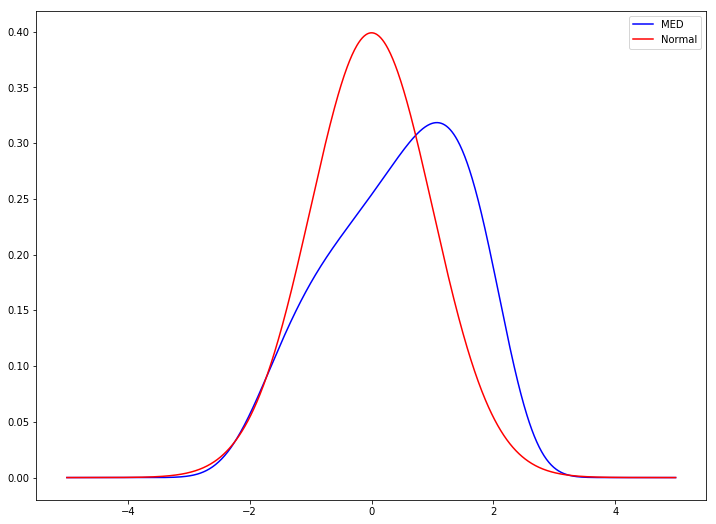

In [266]:
plt.plot(x,y,color='b'), plt.plot(x,ny,color='r'), plt.legend(['MED', 'Normal'])

- Can also use the same techniques to approximate the moments from the density function. 

In [267]:
def est_moment(l,k, N=500000, seed=6710523):
    """
    Estimating the k^th moment of MED given the parameter vector, l. 
    Inputs:
        l: (K,) list.
        Q: normalising constant.
        k: int. The order of moment required. 
    Output:
        m: double. Moment. 
    """
    pf = lambda x: np.power(x,k)*MED_wrapper(x, l)/sps.norm.pdf(x)
    np.random.seed(seed=seed)    
    rx = sps.norm.rvs(size=N)
    m=np.mean(pf(rx))
    return m

In [270]:
[est_moment(l,i+1) for i in range(1,5)]

[1.5633690865847627, 1.4097348658985946, 5.29022396336157, 6.3614151889653705]

- It turns out we can estimate $\lambda$ to produce a density function with the same first $k$ moments (well, as close as one can). 
- Let $\hat{\mu}_k$ denotes the $k^{th}$ sample moments, then 
$$ \hat{\lambda} = \underset{\lambda}{\arg\min} \int^\infty_{-\infty} \exp \left [ \lambda_1 (x-\hat{\mu}_1) + \ldots + \lambda_k (x^k-\hat{\mu}_k ) \right ] dx.$$
- So the objective function can also be approximated by the same technique. 

$$ P(x;\lambda) = \exp \left [ \lambda_1 (x-\hat{\mu}_1) + \ldots + \lambda_k (x^k-\hat{\mu}_k ) \right ] $$ 
$$ \int^\infty_{-\infty}P(x; \lambda) dx= \mathbb{E} \left [ \frac{P(x;\lambda)}{\phi(x)} \right ] $$
where the expectation is taking over a standard normal random variate. 

In [237]:
def Q_Potential(x,l,m):
    k = l.shape[0]
    exponent = np.array([(np.power(x,i+1)-me) for i,me in enumerate(m)])
    f = np.exp(np.dot(l,exponent))
    return f

def Q_Potential_wrapper(l,m, method='N', N=50000, seed=6710523):
    if method == 'N':
        f = lambda x: Q_Potential(x,l,m)
        return spi.quad(f,-np.inf, np.inf)[0]
    elif method == 'MC':
        np.random.seed(seed=seed)
        f = lambda x: Q_Potential(x,l,m)/sps.norm.pdf(x)
        rx = sps.norm.rvs(size=N)
        return np.mean(f(rx))
    else:
        print('Method has not been implemented yet.\n')
        return -1
        

In [271]:
m = pd.read_csv('stock201801-Sem1.csv', header=0, index_col=0)
rm = np.log(m).diff().iloc[1:, :]*100

In [272]:
stock = 'MSFT'
x = rm[stock].values
k = 2
mom = [np.mean(np.power(x,i)) for i in np.arange(1,k+1)]
mom = np.array(mom)
mom

array([0.03483288, 2.6706391 ])

First try with the standard numerical integration

In [278]:
l0 = np.array([0.3,-0.025]) 
obj = lambda l: Q_Potential_wrapper(l,mom)
result = spo.minimize(obj, l0)

In [279]:
result

      fun: 6.752212465439511
 hess_inv: array([[ 0.05574069, -0.00074284],
       [-0.00074284,  0.01039688]])
      jac: array([ 0.0000000e+00, -1.1920929e-07])
  message: 'Optimization terminated successfully.'
     nfev: 52
      nit: 12
     njev: 13
   status: 0
  success: True
        x: array([ 0.01304882, -0.18730621])

In [ ]:
l = copy.copy(result_MC['x']) 
xset = np.arange(-20,20,0.01)
MED_density = lambda x: MED_wrapper(x,l)
entp = MED_density(xset)
plt.hist(rm['MSFT'].values, bins=200, density=True)
norm = sps.norm.pdf(xset,loc=rm['MSFT'].mean(), scale=rm['MSFT'].std())

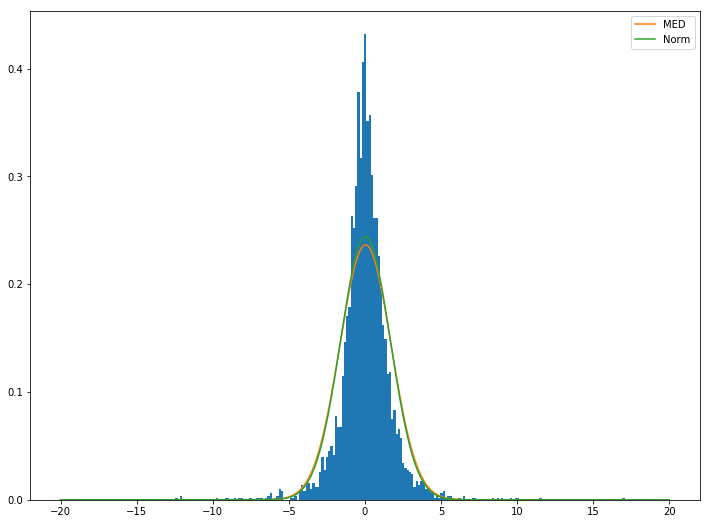

In [280]:
plt.plot(xset,entp)
plt.plot(xset,norm)
plt.legend(['MED', 'Norm'])

Now with MC Integration

In [281]:
l0 = np.array([0.3,-0.025]) 
obj = lambda l: Q_Potential_wrapper(l,mom, method='MC')
result_MC = spo.minimize(obj, l0)

In [282]:
result_MC

      fun: 6.7228752665028875
 hess_inv: array([[ 0.05821733, -0.0009732 ],
       [-0.0009732 ,  0.01282374]])
      jac: array([ 8.34465027e-06, -4.29153442e-06])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([ 0.01294346, -0.17597205])

- How close are the moments from the estimated density to the sample moments it means to match? 

In [283]:
np.array([est_moment(l,i) for i in np.arange(1,5)]), mom

(array([ 0.05419533,  2.74595021,  0.57340142, 20.97967172]),
 array([0.03483288, 2.6706391 ]))

- Not fantastic but close. 
- Need a few tweaks to make it work better 

**Exercise: Can you improve this procedure?**

**Hint**: Using the normal distribution is generally not the best choice. It is used here for demonstration purposes but there are better alternatives. See if you can find one... 

How does it work for $k=3$? 

In [291]:
stock = 'MSFT'
x = rm[stock].values
k = 3
mom4 = [np.mean(np.power(x,i)) for i in np.arange(1,k+1)]
mom4 = np.array(mom4)

In [286]:
l0 = np.array([0.3,-0.025,0]) 
obj = lambda l: Q_Potential_wrapper(l,mom4, method='MC')
result_MC = spo.minimize(obj, l0)

In [287]:
result_MC

      fun: 6.7207198234727725
 hess_inv: array([[ 1.76650313e-01,  8.81469918e-05, -1.80878034e-02],
       [ 8.81469918e-05,  1.24486257e-02, -2.21012371e-04],
       [-1.80878034e-02, -2.21012371e-04,  2.64622766e-03]])
      jac: array([1.19209290e-07, 1.25169754e-06, 1.31130219e-06])
  message: 'Optimization terminated successfully.'
     nfev: 90
      nit: 13
     njev: 18
   status: 0
  success: True
        x: array([-0.0111398 , -0.1760114 ,  0.00342503])

In [ ]:
l = copy.copy(result_MC['x'])
xset = np.arange(-20,20,0.01)
MED_density = lambda x: MED_wrapper(x,l)
entp = MED_density(xset)
plt.hist(rm['MSFT'].values, bins=200, density=True)
norm = sps.norm.pdf(xset,loc=rm['MSFT'].mean(), scale=rm['MSFT'].std())

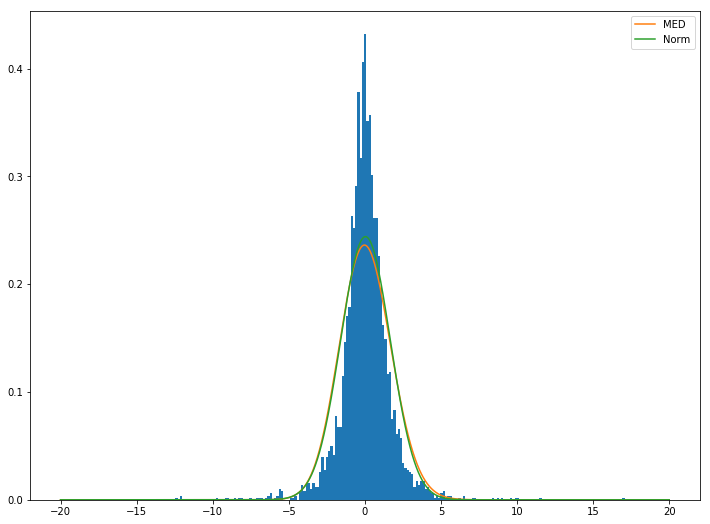

In [288]:
plt.plot(xset,entp)
plt.plot(xset,norm)
plt.legend(['MED', 'Norm'])

In [290]:
np.array([est_moment(l,i) for i in np.arange(1,5)])

array([ 0.06026537,  2.76524009,  0.89299953, 21.37762544])

## Conclusion 

- Introduced two basic concepts of Monte Carlo Integration techniques. 
- Hit and Miss and Importance sampling. 
- Introduced the concept of WLLN. 